# FunOS module initialization analysis

This notebook analyze module initilzation, durations and dependencies.
Input file is `modules.json`.

**References** for the notebook:
- [Using simple barh based implementation](https://towardsdatascience.com/gantt-charts-with-pythons-matplotlib-395b7af72d72)
- [Barh based with hints on how to make better representation](https://medium.com/geekculture/generate-gantt-chart-in-python-9d1e1fe9103e)

TODO:
- check plotly one more time (just use line chart ?) or use gannt style, which requre datetime conversion

In [25]:
# *NOTE*: run this command to clean output cell and meta data.

#nb-clean clean  ./funos_stats_analysis/fun_module_init_analysis.ipynb

In [26]:
# html gen
# cd Projects/Fng/FunTools/dpcsh_interactive_client/src
# ./dpcsh_interactive_client/convert_nb.py --filename ./funos_stats_analysis/fun_module_init_analysis.ipynb --execute 
# scp ./funos_stats_analysis/fun_module_init_analysis.html vnc-shared-07:/dogfood/users/insop/html/modules_init 

In [27]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Tuple
import yaml
import json

%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

#https://stackoverflow.com/questions/36288670/how-to-programmatically-generate-markdown-output-in-jupyter-notebooks
from IPython.display import display, Markdown, Latex

In [28]:
DEBUG=False

In [29]:
def _fmt(s, show_d=True):
    """show decimal number with comma"""
    if show_d:
        return format(s, ",d")
    else:
        return s

In [30]:
def convert_to_list_of_dicts(raw_data: dict, convert_time_to_ns: bool, debug: bool) -> list:
    """convert the raw data (dict based format) to list of dicts

    Parameters
    ----------
    raw_data : dict
        raw data in dict format, module_name: [start_time, end_time]
    
    convert_time_to_ns : bool, optional
        convert time to ns, by default True
    
    Returns
    -------
    fun_module_init_list : list
        list of dicts, each dict is a module, with keys: module_name, start_time, finish_time
    """
    time_unit = 0
    if convert_time_to_ns:
        time_unit = 1000000000
    fun_module_init_list = []
    for module_name, module_data in raw_data.items():
        temp_dict = {}
        temp_dict['module_name'] = module_name
        temp_dict['start_time'] = time_unit * float(module_data[0])
        temp_dict['finish_time'] = time_unit * float(module_data[1])
        # add duration column
        temp_dict['module_init_duration'] = temp_dict['finish_time'] - temp_dict['start_time']
        fun_module_init_list.append(temp_dict)

    if debug:
        print("List created")
        print(fun_module_init_list[:2])
        print("Time conversion unit: {}".format(time_unit))
        # convert list of dicts to pandas dataframe
        # fun_module_init_df = pd.DataFrame(fun_module_init_list)
        # fun_module_init_df.head()
    
    return fun_module_init_list

In [31]:
def load_input_data(input_file: str, convert_time_to_ns: bool = True, debug: bool=False) -> pd.DataFrame:
    """load input data from json file and convert to pandas dataframe

    Parameters
    ----------
    input_file : str
        input file name
    
    Returns
    -------

    fun_module_init_df : pd.DataFrame
        pandas dataframe with module_name, start_time, finish_time, module_init_duration

    """
    with open(input_file, 'r') as f:
        fun_module_init = json.load(f)
    
    if debug:
        print("Number of modules: {}".format(len(fun_module_init)))
        print("fun_module_init.keys: {}".format(fun_module_init.keys()))
        print("fun_module_init['accel_telem-init']: {}".format(fun_module_init['accel_telem-init']))

    # convert to list of dicts
    fun_module_init_list = convert_to_list_of_dicts(fun_module_init, convert_time_to_ns=convert_time_to_ns, debug=debug)

    # convert to df
    fun_module_init_df = pd.DataFrame(fun_module_init_list)
    fun_module_init_df.set_index('module_name', inplace=True)

    return fun_module_init_df


## Load `modules.json` file and convert it to dataframe

Example input:
```
{
    "accel_telem-init": [0.024845458, 0.024987833],
    "adi-init": [0.040308791, 0.040344291],
    "app-init": [0.029524875, 0.029535041],
...
```

Example output:
```
	module_name	start_time	finish_time
0	accel_telem-init	0.024845	0.024988
1	adi-init	0.040309	0.040344
2	app-init	0.029525	0.029535
3	bin_ctl_handler-init	0.002356	0.002492
4	bm-init	0.030727	0.030735
```

In [32]:
# load config, TODO use config file

# INPUT_FILE = "modules_posix.json"
INPUT_FILE = "modules.json"

In [33]:
# MAIN CALLS
# load input data

note_str = '### Checking data from `modules.json`'
display(Markdown(note_str))

fun_module_init_df = load_input_data(INPUT_FILE, convert_time_to_ns=True, debug=False)
fun_module_init_df.head()

### Checking data from `modules.json`

,start_time,finish_time,module_init_duration
module_name,,,
accel_telem-init,1.535963e+10,1.535971e+10,74944.0
adi-init,1.309754e+10,1.309756e+10,15217.0
bin_ctl_handler-init,3.415369e+07,3.437486e+07,221171.0
bm_pool_config-init,2.686806e+08,2.713919e+08,2711301.0
board_manager-init,3.438188e+07,2.332302e+08,198848338.0


In [34]:
note_str = '### Summary: time in ns'
display(Markdown(note_str))

fun_module_init_df.describe().round()

### Summary: time in ns

,start_time,finish_time,module_init_duration
count,1.230000e+02,1.230000e+02,1.230000e+02
mean,1.314134e+10,1.319885e+10,5.751016e+07
std,5.999831e+09,6.045778e+09,5.281959e+08
min,2.288050e+05,4.265500e+05,1.137100e+04
25%,1.309743e+10,1.309755e+10,5.234400e+04
50%,1.536171e+10,1.536216e+10,1.977450e+05
75%,1.563899e+10,1.563910e+10,8.024100e+05
max,2.207271e+10,2.207283e+10,5.841745e+09


In [35]:
note_str = "Total number of modules: {}".format(len(fun_module_init_df))
display(Markdown(note_str))

Total number of modules: 123

## Plot all module init

In [36]:
import plotly.express as px
import plotly.graph_objects as go

In [37]:
def get_start_finish_times(df: pd.DataFrame, debug: bool = False) -> pd.DataFrame:
    """Utility to get start and finish times from df"""

    start_min = df['start_time'].min() # first module start time
    finish_max = df['finish_time'].max() # last module finish time
    duration = finish_max - start_min # time between the first module start time and last module finish time

    if debug:
        print("start_min (start time of the first module): {}".format(start_min))
        print("finish_max: (finish time of the last module) {}".format(finish_max))
        # print("duration: (finish_max - start_min) {}".format(finish_max - start_min))
        # summary
        total_module_time = df['module_init_duration'].sum()
        print("Total module init time: {} ns".format(total_module_time))
        print("duration (time between the first module start time and last module finish time): {} ns".format(finish_max - start_min))
        print("'Total module init time' / 'duration' (greater than 1 is better, which means more concurrent modules init): {} ".format(((total_module_time / duration)).round(4)))
    
    return start_min, finish_max, duration

In [51]:
def plot_module_time_chart(df: pd.DataFrame, small_set: int=-1, use_plt: bool=True, sort_by: str="start_time", title: str='FunOS Module Init Duration', group_table: dict=None, simple_group_name: bool=True, cutoff_group_names: int=10, save_file_name: str ="fun_module_init_chart", disp_granualarity_ms: int=10, debug: bool=False) -> None:
    """Plot the module init time chart
    Parameters
    ----------
    df : pd.DataFrame
        dataframe with module init data
    small_set : int, optional
        number of rows to plot, by default -1 (plot all)
    sort_by : str, optional
        sort by column, by default "start_time"
    title : str, optional
        title of the chart, by default 'FunOS Module Init Duration'
    group_table : dict, optional
        group table, by default None, if not None, group the modules based on the group_table
    simple_group_name : bool, optional
        use simple group name, by default True
    cutoff_group_names : int, optional
        cutoff group names, by default 12, cut off text display for group names
    disp_granualarity_ms: int, optional
        X axis display granualarity, in ms time unit, by default 10
    
    Returns
    -------
    None
    """
    # add max min for creating tick

    df_use = df.copy()

    X_disp_granualarity = disp_granualarity_ms
    X_granualarity = 1000000
    x_tick_str = "ms"
    # if X_granualarity == 1000000:
    #     x_tick_str = "ms"
    # elif X_granualarity == 1000000000:
    #     x_tick_str = "s"

    df_use.sort_values(by=[sort_by], inplace=True, ascending=True)

    if small_set > 0:
        df_use = df_use[:small_set]

    if save_file_name[-4:] != ".png":
        save_file_name = save_file_name + ".png"
    
    start_min, finish_max, duration = get_start_finish_times(df_use, debug=debug)

    x_ticks = np.arange(0, duration, X_disp_granualarity * X_granualarity)
    x_tick_labels = ["{} {}".format(str(int(x)), x_tick_str) for x in x_ticks/X_granualarity]

    figsize=(40, len(df_use))
    
    if debug:
        print("x_ticks: {}".format(x_ticks[:10]))
        print("x_tick_labels: {}".format(x_tick_labels[:10]))
        print("figsize: {}".format(figsize))


    if debug:
        display(df_use.head())
        display(df_use.describe())

    if use_plt:
        # fig, ax = plt.subplots(1, figsize=(40, 50))
        fig, ax = plt.subplots(1, figsize=figsize)
        p1 = ax.barh(df_use.index, width=df_use['module_init_duration'], left=df_use['start_time'])

        ax.set(xlabel='ms', ylabel='Modules')

        #Invert y axis
        plt.gca().invert_yaxis()

        #customize x-ticks
        plt.xticks(ticks=x_ticks, labels=x_tick_labels)

        # title
        if group_table:
            title = "{}: collapsed".format(title)
        plt.title(title, fontsize=20)

        #rotate x-ticks
        plt.xticks(rotation=60)
        #add grid lines
        plt.grid(axis='x', alpha=0.5)
        plt.grid(axis='y', alpha=0.5)
        # test

        if group_table:
            if simple_group_name:
                # testing simpler way
                y_pos = np.arange(len(group_table))
                y_label = ["{} & {} modules".format(v[0], len(v)) if len(v) > 1 else v[0] for k, v in group_table.items()]
                ax.set_yticks(y_pos, labels=y_label)
                pass
            else:
                x_base = 6000000
                for i, (k, v) in enumerate(group_table.items()):
                    # print("i: {}, k: {} ({}), v: {}".format(i, k, len(v), v))
                    if len(v) > cutoff_group_names:
                        v_str = "{}...(total: {})".format(v[:cutoff_group_names], len(v))
                    else:
                        v_str = "{}".format(v)
                    ax.text(x_base*(i+1), i, v_str, fontsize=21, color='red')
                    # ax.text(20000000, 1, 'Unicode: Institut für Festkörperphysik')

        #save fig
        plt.savefig(save_file_name)
        plt.show()
    else:
        # use plotly
        # plotly doesn't support 'left' argument, so need to create manualy bars
        # https://community.plotly.com/t/broken-barh-plot/36496
        # assert False, "Ploty not supported yet"

        df_use.sort_values(by=[sort_by], inplace=True, ascending=False)

        # fig = px.bar(df, x="module_init_duration", y=df.index, orientation='h', height=1000)
        

        # fig = go.Figure(go.Bar(
        #     x=df["module_init_duration"],
        #     y=df.index,
        #     orientation='h'))

        fig = go.Figure()
        fig.add_trace(go.Bar(
            y=df_use.index,
            x=df_use["start_time"],
            name='start',
            orientation='h',
            # width=20,
            marker=dict(
                color='rgba(256, 256, 256, 0.0)',
                line=dict(color='rgba(256, 256, 256, 0.0)', width=1)
            )
        ))

        fig.add_trace(go.Bar(
            y=df_use.index,
            x=df_use["module_init_duration"],
            name='module init duration',
            orientation='h',
            # width=20,
            marker=dict(
                color='rgba(58, 71, 80, 0.6)',
                line=dict(color='rgba(58, 71, 80, 1.0)', width=3)
            )
        ))

        fig.update_layout(barmode='stack')


        fig.show()
        # fig = px.timeline(df, x_start="start_time", x_end="finish_time", y=df_use.index, title=title)
        # fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
        # fig.show()

    del df_use

In [39]:
def dump_file(df: pd.DataFrame, file_name: str, sorted_key: str = None):
    """Dump the dataframe to a file

    Parameters
    ----------
    df : pd.DataFrame
        dataframe to dump
    file_name : str
        file name to dump to
    sorted_key : str, optional
        key to sort the dataframe, by default None
    """

    
    # save df to json file
    sorted_df = df.copy()
    if sorted_key:
        sorted_df.sort_values(by=[sorted_key], inplace=True, ascending=True)
    
    txt_file_name = file_name + ".txt"
    with open(txt_file_name, "w") as f:
        f.write(sorted_df.to_string())
    sorted_df_file_name = file_name
    json_file_name = sorted_df_file_name + ".json"
    sorted_df.to_json(json_file_name)
    csv_file_name = sorted_df_file_name + ".csv"
    sorted_df.to_csv(csv_file_name)

    yaml_file_name = sorted_df_file_name + ".yaml"
    with open(yaml_file_name, "w") as f:
        yaml.dump({'result': json.loads(sorted_df.to_json(orient='records'))}, f, default_flow_style=False)

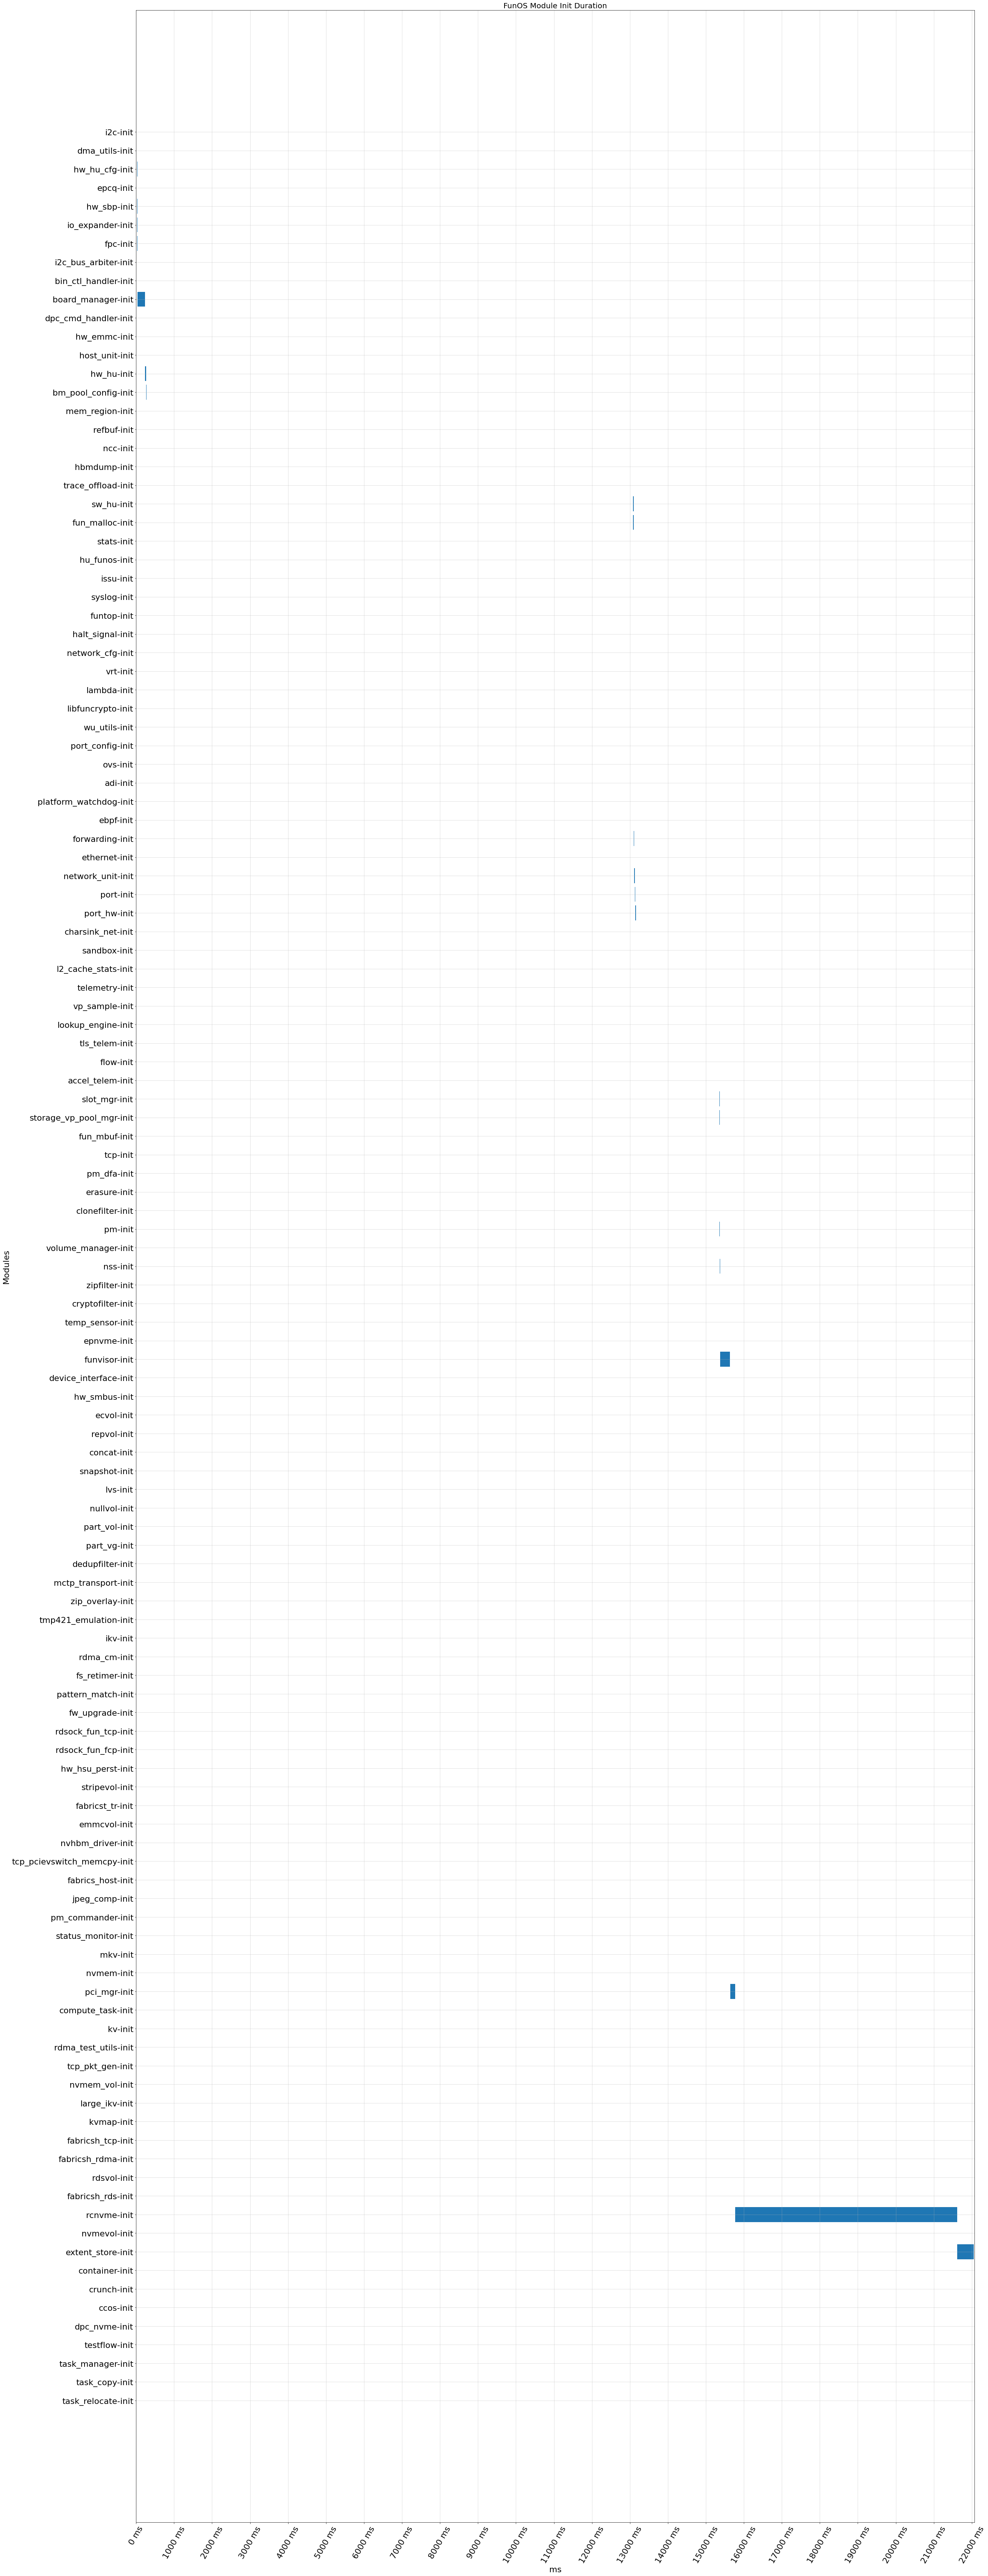

In [40]:
# MAIN CALLS
# plot the events
plot_module_time_chart(fun_module_init_df, disp_granualarity_ms=1000, debug=False)

In [41]:
if DEBUG:
    fun_module_init_df.loc[['forwarding-init', 'network_unit-init', 'ethernet-init']]
    # fun_module_init_df.index
    # fun_module_init_df.columns

In [42]:
# MAIN CALLS

sorted_df_file_name = "fun_module_init_df_sorted"
dump_file(fun_module_init_df, sorted_df_file_name, "start_time")

## Collapsing short activities

In [43]:
def get_duration_threshold(df: pd.DataFrame, threshold: float=0.10) -> float:
    """Get the threshold value from the dataframe
    Parameters
    ----------
    df : pd.DataFrame
        dataframe with module init data
    threshold : float, optional
        threshold value, by default 0.10
    Returns
    -------
    float
        threshold value
    """
    max_duration = df['module_init_duration'].max()

    return float(int(max_duration * threshold))


In [44]:
def get_collapsed_df(df_in:pd.DataFrame, threshold: float, debug: bool = False) -> Tuple[pd.DataFrame, dict]:
    """Collpased df using the threshold

    Parameters
    ----------
    df : pd.DataFrame
        dataframe with module init data
    threshold : float
        threshold value to collapse, fraction to the largest duration
        ex> 0.10 means collapse all the modules with duration less than 10% of the largest duration

    Returns
    -------
    pd.DataFrame
        collapsed dataframe
    dict
        group table, key is the group name, value is the list of modules in the group
    """

    df = df_in.copy()
    df.sort_values(by=['start_time'], inplace=True, ascending=True)

    # df_collapsed['module_init_duration'] = df_collapsed['module_init_duration'].apply(lambda x: x if x > threshold else 0)
    # df_collapsed = df_collapsed[df_collapsed['module_init_duration'] > 0]
    new_events = []
    n_event = 0
    num_included = 0
    cur_duration = 0 # current start to the finish of the last event
    cur_start = 0
    cur_finish = 0
    last = len(df)
    group_table = {}
    for i in range(len(df)):
        name, start, finish, duration = df.index[i], df.iloc[i].start_time, df.iloc[i].finish_time, df.iloc[i].module_init_duration
        if debug:
            print(name, start, finish, duration)

        if cur_duration == 0:
            num_included = 0
            cur_duration = duration
            cur_start = start
            cur_finish = finish
            group_modules = []
        
        cur_finish = max(cur_finish, finish)
        cur_duration = cur_finish - cur_start
        # print("cur_start, cur_finish, cur_duration: {}, {}".format(cur_start, cur_finish, cur_duration))

        # peek the next check if next module passes the thresholds
        next_module_pass_threshold = False
        if i < last - 1:
            next_name, next_start, next_finish, next_duration = df.index[i+1], df.iloc[i+1].start_time, df.iloc[i+1].finish_time, df.iloc[i+1].module_init_duration
            next_finish = max(cur_finish, next_finish)
            # print("next_finish {}, next_finish - cur_start {}".format(next_finish, next_finish - cur_start))
            # if next duration is more than threshold and there is more than one collapsed, then stop collapsing the current modules
            # if next_finish - cur_start > threshold and num_included > 0:
            if next_finish - cur_start > threshold:
                next_module_pass_threshold = True
                group_modules.append(name)

        
        # if cur_duration + duration > threshold:
        if cur_duration > threshold or next_module_pass_threshold:
            # peek the next one and keep adding until the threshold is reached
            # create a new onew
            group_name = "group_{}".format(n_event)
            new_d = {"module_name" : group_name, "start_time" : cur_start, "finish_time" : cur_finish, "module_init_duration" : cur_duration}
            if debug:
                print("includes {}, added: {}".format(num_included, new_d))
            new_events.append(new_d)
            cur_duration = 0
            n_event += 1
            group_table[group_name] = group_modules if num_included > 0 else [name]
            # group_modules = []
        else:
            group_modules.append(name)
            num_included += 1
                
    if cur_duration != 0:
        group_name = "group_{}".format(n_event)
        new_d = {"module_name" : group_name, "start_time" : cur_start, "finish_time" : cur_finish, "module_init_duration" : cur_duration}
        if debug:
            print("added: {}".format(new_d))
        new_events.append(new_d)
        group_table[group_name] = group_modules

    df_collapsed = pd.DataFrame(new_events)
    df_collapsed.set_index('module_name', inplace=True)
    df_collapsed.head()
    
    return df_collapsed, group_table

In [45]:
def print_group_table(group_table: dict, threshold: float, save_file_name: str = None):
    """Print the group table

    Parameters
    ----------
    group_table : dict
        group table, key is the group name, value is the list of modules in the group
    threshold : float
        threshold (nsec) value to collapse, fraction to the largest duration
    save_file_name : str, optional
        file to save the group table, by default None
    """
    output  = "Collapsed module group report (threshold time of {} ns):\n".format(threshold)
    output += "========================\n"
    for key, value in group_table.items():
        output += ("{}({}): {}\n".format(key, len(value), value))
        # print("{}({}): {}".format(key, len(value), value))

    print(output)

    if save_file_name:
        if save_file_name[:-4] != ".txt":
            save_file_name += ".txt"
        with open(save_file_name, "w") as f:
            f.write(output)
    
    # for k, v in group_table.items():
    #     print("{}:".format(k))
    #     for m in v:
    #         print("  {}".format(m))

Collapse module init time lower than threshold (58,417,448 ns)

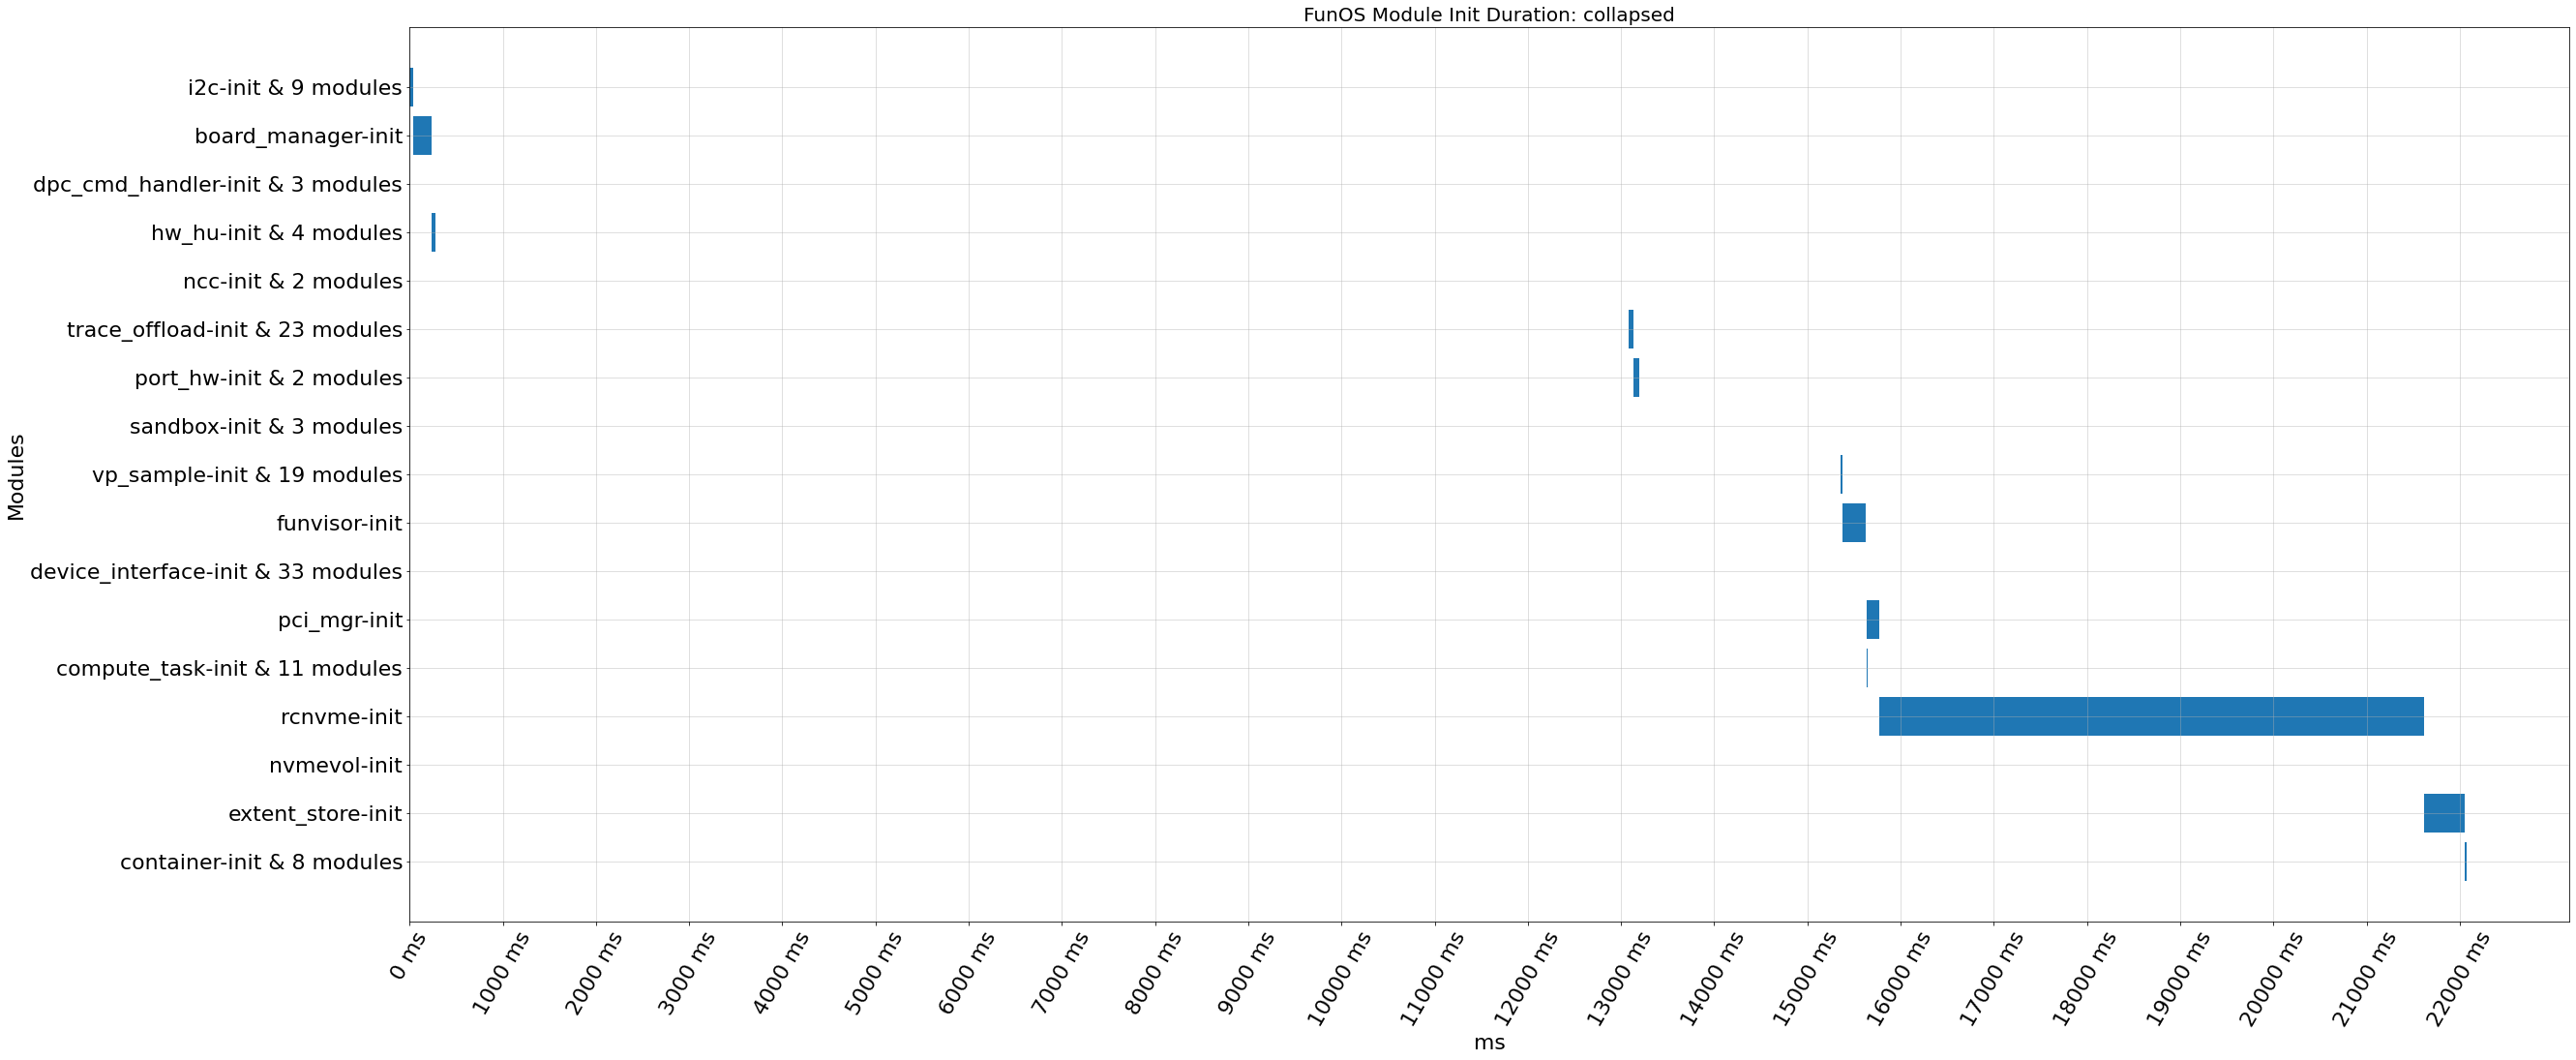

Collapsed module group report (threshold time of 58417448.0 ns):
group_0(9): ['i2c-init', 'dma_utils-init', 'hw_hu_cfg-init', 'epcq-init', 'hw_sbp-init', 'io_expander-init', 'fpc-init', 'i2c_bus_arbiter-init', 'bin_ctl_handler-init']
group_1(1): ['board_manager-init']
group_2(3): ['dpc_cmd_handler-init', 'hw_emmc-init', 'host_unit-init']
group_3(4): ['hw_hu-init', 'bm_pool_config-init', 'mem_region-init', 'refbuf-init']
group_4(2): ['ncc-init', 'hbmdump-init']
group_5(23): ['trace_offload-init', 'sw_hu-init', 'fun_malloc-init', 'stats-init', 'hu_funos-init', 'issu-init', 'syslog-init', 'funtop-init', 'halt_signal-init', 'network_cfg-init', 'vrt-init', 'lambda-init', 'libfuncrypto-init', 'wu_utils-init', 'port_config-init', 'ovs-init', 'adi-init', 'platform_watchdog-init', 'ebpf-init', 'forwarding-init', 'ethernet-init', 'network_unit-init', 'port-init']
group_6(2): ['port_hw-init', 'charsink_net-init']
group_7(3): ['sandbox-init', 'l2_cache_stats-init', 'telemetry-init']
group_8(19): [

In [46]:
# MAIN CALLS
threshold = get_duration_threshold(fun_module_init_df, threshold=0.01)
note_str = "Collapse module init time lower than threshold ({} ns)".format(_fmt(int(threshold), True))
display(Markdown(note_str))

fun_module_init_df_collapsed, group_table = get_collapsed_df(fun_module_init_df, threshold, debug=False)
save_file_name = "fun_module_init_df_collapsed"
plot_module_time_chart(fun_module_init_df_collapsed, disp_granualarity_ms=1000, debug=False, group_table=group_table, save_file_name=save_file_name)

print_group_table(group_table, threshold=threshold, save_file_name=save_file_name)

In [47]:
stop here


SyntaxError: invalid syntax (1116318007.py, line 1)

In [52]:
# debugging
plot_module_time_chart(fun_module_init_df, use_plt=False, disp_granualarity_ms=1000, debug=False)

In [53]:
# debugging
plot_module_time_chart(fun_module_init_df_collapsed, use_plt=False, disp_granualarity_ms=1000, debug=False, group_table=group_table, save_file_name=save_file_name)

In [58]:
# from https://community.plotly.com/t/broken-barh-plot/36496/2

def broken_bars(xstart, xwidth, ystart, yh, colors):
    #xstart - list of x-start coord for each bar
    #xwidth = list of bar widths
    #ystart - number y-start coord for each bar
    #yh - number- height of eah bar
    #colors = list of bar colors
    
    if len(xstart) != len(xwidth) or  len(xstart) != len(colors):
        raise ValueError('xstart, xwidth and colors must have the same length')
    shapes = []    
    for k in range(len(xstart)):
        shapes.append(dict(type="rect",
                           x0=xstart[k],
                           y0=ystart,
                           x1=xstart[k] + xwidth[k],
                           y1=ystart+yh,
                           fillcolor=colors[k],
                           line_color=colors[k]))
    return shapes    


fig = go.Figure()
fig.update_layout(width=600, height=500,
                  xaxis_range = [0, 150],
                  yaxis_range = [0, 40],
                  shapes=broken_bars([10, 100, 130 ], [50, 20, 10], 20, 9, 
                                     colors=['orange', 'green', 'red' ]))
fig.show()

In [59]:
def broken_bars2(xstart, xwidth, ystart, yh, colors):
    #the same tests as above
    data =[]
    for k in range(len(xstart)):
        data.append(go.Scatter(x = [xstart[k], xstart[k]+xwidth[k],xstart[k]+xwidth[k], xstart[k]],
                               y = [ystart]*2+[ystart+yh]*2, fill='toself', fillcolor=colors[k], mode='lines',
                               line_color=colors[k], name=f'bar{k}'))
                    
    return data
fig = go.Figure(data= broken_bars2([10, 100, 130 ], [50, 20, 10], 20, 9, 
                                     colors=['orange', 'green', 'red' ]))
fig.update_layout(width=600, height=500,
                  xaxis_range = [0, 150],
                  yaxis_range = [0, 40]);
fig.show()

In [ ]:
# save df to json file
sorted_df = fun_module_init_df.copy()
sorted_df.sort_values(by=['start_time'], inplace=True, ascending=True)
sorted_df_file_name = "fun_module_init_df_sorted"
json_file_name = sorted_df_file_name + ".json"
sorted_df.to_json(json_file_name)
csv_file_name = sorted_df_file_name + ".csv"
sorted_df.to_csv(csv_file_name)

yaml_file_name = sorted_df_file_name + ".yaml"
with open(yaml_file_name, "w") as f:
    yaml.dump({'result': json.loads(sorted_df.to_json(orient='records'))}, f, default_flow_style=False)


In [ ]:
# do sanity check
print("len of fun_module_init_df: {}".format(len(fun_module_init_df)))

In [ ]:
count = 0
for k,v in group_table.items():
    count += len(v)
print("len of group_table: {}".format(count))

In [ ]:
test_df = fun_module_init_df.copy()

In [ ]:
test_df.sort_values(by=['start_time'], inplace=True, ascending=True)

In [ ]:
test_df.head(30).round()

In [ ]:
test_df.loc[['funvisor-init']].round()

In [ ]:
test_df.round().tail(30)

In [ ]:
small_df = fun_module_init_df.copy()

In [ ]:
small_df.sort_values(by=['start_time'], inplace=True, ascending=True)

In [ ]:
small_df.head()

In [ ]:
# t = small_df[:42]
t = small_df
display(t)

In [ ]:
plot_module_time_chart(t, debug=False)

In [ ]:
threshold

In [ ]:
new_events = []
n_event = 0
num_included = 0
cur_duration = 0 # current start to the finish of the last event
cur_start = 0
cur_finish = 0
last = len(t)
group_table = {}
for i in range(len(t)):
    name, start, finish, duration = t.index[i], t.iloc[i].start_time, t.iloc[i].finish_time, t.iloc[i].module_init_duration
    print(name, start, finish, duration)

    if cur_duration == 0:
        num_included = 0
        cur_duration = duration
        cur_start = start
        cur_finish = finish
        group_modules = [name]
    
    cur_finish = max(cur_finish, finish)
    cur_duration = cur_finish - cur_start
    # print("cur_start, cur_finish, cur_duration: {}, {}".format(cur_start, cur_finish, cur_duration))

    # peek the next check if next module passes the thresholds
    next_module_pass_threshold = False
    if i < last - 1:
        next_name, next_start, next_finish, next_duration = t.index[i+1], t.iloc[i+1].start_time, t.iloc[i+1].finish_time, t.iloc[i+1].module_init_duration
        next_finish = max(cur_finish, next_finish)
        # print("next_finish {}, next_finish - cur_start {}".format(next_finish, next_finish - cur_start))
        # if next duration is more than threshold and there is more than one collapsed, then stop collapsing the current modules
        if next_finish - cur_start > threshold and num_included > 0:
            next_module_pass_threshold = True
    
    # if cur_duration + duration > threshold:
    if cur_duration > threshold or next_module_pass_threshold:
        # peek the next one and keep adding until the threshold is reached
        # create a new onew
        group_name = "group_{}".format(n_event)
        new_d = {"module_name" : group_name, "start_time" : cur_start, "finish_time" : cur_finish, "module_init_duration" : cur_duration}
        print("includes {}, added: {}".format(num_included, new_d))
        new_events.append(new_d)
        cur_duration = 0
        n_event += 1
        group_table[group_name] = group_modules if num_included > 0 else [name]
        group_modules = []
    else:
        group_modules.append(name)
        num_included += 1
        pass
            
if cur_duration != 0:
    group_name = "group_{}".format(n_event)
    new_d = {"module_name" : group_name, "start_time" : cur_start, "finish_time" : cur_finish, "module_init_duration" : cur_duration}
    print("added: {}".format(new_d))
    new_events.append(new_d)
    group_table[group_name] = group_modules

new_events

In [ ]:
t_str = group_table['group_6']
t_str1 = ','.join(t_str)
t_str1

In [ ]:
group_table_str = []
for k, v in group_table.items():
    dict = {}
    dict["group_name"] = k
    dict["modules"] = ','.join(v)
    group_table_str.append(dict)

# display(group_table_str)
for d in group_table_str:
    print("{}: {}".format(d["group_name"], d["modules"]))

for k, v in group_table.items():
    print("{}:".format(k))
    for m in v:
        print("  {}".format(m))
    # print("{}: {}".format(d["group_name"], d["modules"]))

# group_table_str_df = pd.DataFrame(group_table_str)
# group_table_str_df

In [ ]:
display(group_table)
# group_table_df = pd.DataFrame.from_dict(group_table, orient='index')
# display(group_table_df)


In [ ]:
new_df = pd.DataFrame(new_events)
new_df.set_index('module_name', inplace=True)
new_df.head()

In [ ]:
plot_module_time_chart(new_df, debug=False)

In [ ]:
15228333.0 - 15216708.0

In [ ]:
15257625.0-15228333.0

In [ ]:
t1 = small_df[-42:]
display(t1)

In [ ]:
plot_module_time_chart(t1, small_set=-1, debug=False)